# SVM Fundamentals
### Overview
Sources:
* [SVM in Depth](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

Steps:
* Explain linear SVM using plots to highlight the hyperplane, decision boundaries and support vectors
* Explain kernel SVM (specifically RBF) using plots to highlight transformation of data into higher dimensions (3D map)
* Explain multi-class SVM using plots to display the differences between different kernels results
* Explain hyperparameter tuning (C, gamma) using plots to explain each (i.e. margin widths, sample size effect)
* Use GridSearch and other methods to optimize the selection of hyperparameter values (C, gamma)
* Assess accuracy using a heatmap of a confusion matrix

### 1. Linear SVM
Steps:
* Generate linearly separable data
* Create a linear SVM model and fit to the data
* Display SVM hyperplane and decision boundaries
* Documentation:
    * [Plotting SVM Data](https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html)
    * [SVM SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    * [Generating Test Data](https://machinelearningmastery.com/generate-test-datasets-python-scikit-learn/)

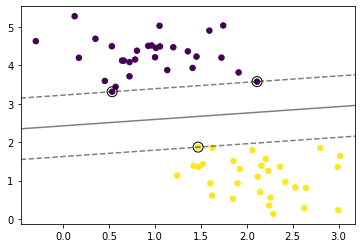

In [31]:
# load libraries
import numpy as np
from sklearn import svm
from sklearn.datasets import make_blobs # generates clusters with Gaussian distribution
import matplotlib.pyplot as plt
%matplotlib inline

# generate clustered data for linearly separable data
X, y = make_blobs(n_samples=60, centers=2, random_state=0, cluster_std=0.5)

# create SVM model with linear kernel
clf = svm.SVC(kernel='linear', C=1000) # high C to begin with (more later)

# fit model to data
clf.fit(X, y)

# method to plot SVM
def plot_svc_decision_function(model, ax=None, ):

    # plot data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30)

    # define plot
    if ax == None:
        ax = plt.gca() # get current axis of above scatter
    xlim = ax.get_xlim() # get x and y ranges for axes
    ylim = ax.get_ylim()

    # create grid of points
    xx = np.linspace(xlim[0], xlim[1], 30) # create x-axis range
    yy = np.linspace(ylim[0], ylim[1], 30) # create y-axis range
    YY, XX = np.meshgrid(yy, xx) # create grid of above points for plot bg/surface
    xy = np.vstack([XX.ravel(), YY.ravel()]).T # create x, y coordinates for entire grid (i.e. 30x30)
    Z = model.decision_function(xy).reshape(XX.shape) # plot straight line function of model and match shape to inputs

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', # plot x, y and z (i.e. right/left, up/down and height of contours)
               levels=[-1, 0, 1], linestyles=['--', '-', '--'], # define levels and line styles of contours
               alpha=0.5) # opacity/blending of layer lines

    # plot support vectors
    ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, # plot x, y coords of support vectors
               linewidth=1, facecolors='none', edgecolors='k') # essentially large circles with no filling
    
# plot data
plot_svc_decision_function(clf)

Summary:
* **Support Vectors** are the data points which are closest to our hyperplane and used to define our margins, these are used to calculate the maximum margin distance
* SVM maximises the distance between each class to create the optimal hyperplane/boundary between classes for use in future classification
* We used a simple linear kernel because our data is linearly separable, this is the simplest example of SVM classification

### Support Vectors and 'C' Parameter
Let's have a quick look at the effect of the C parameter given different sample sizes/numbers of vectors.

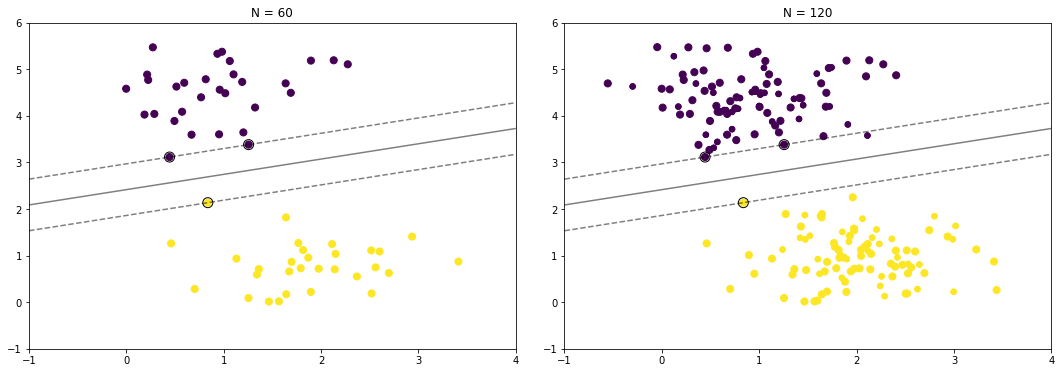

In [32]:
# plot SVM with N vectors
def plot_svm(N=10, ax=None):
    
    # generate clustered data for linearly separable data
    X, y = make_blobs(n_samples=200, centers=2, random_state=0, cluster_std=0.60)
    
    # extract N samples from X and y vars
    X = X[:N]
    y = y[:N]
    
    # create SVM model with linear kernel
    clf = svm.SVC(kernel='linear', C=1000000).fit(X, y) # high C to prevent misclassification
    
    # plot data
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(clf, ax)

# plot side by side to show effect of different numbers of N/vectors
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

As you can see, when we have a high value of C set, it doesn't matter how many vectors we have, the SVM solution is identical. This is because a high value of C means that it has a low tolerance for misslassification and sets more conservative margins to reduce the error rate. If we were to reduce C then the margins would extend further and we would have some missclassification. Essentially, this is a trade off between sensitivity and overfitting.

### Kernel SVM
Steps:
* Generate non-linearly separable data
* Plot to show distribution of non-linear classes
* Use kernel SVM (radial basis function) to map raw, lower dimensional data to higher dimension

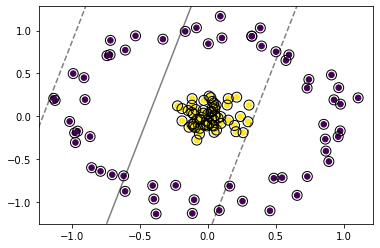

In [33]:
# load libraries
from sklearn.datasets import make_circles

# generate non-linearly separable data
X, y = make_circles(n_samples=120, factor=0.1, noise=0.1)

# create and fit SVM model with linear kernel
clf = svm.SVC(kernel='linear').fit(X, y)

# plot data
plot_svc_decision_function(clf)

You can see in the above image that this dataset is not linearly separable and that a linear model is useless for classifying it, therefore we must use a kernel (RBF here) to transform our data into a higher dimensional state to solve the problem linearly there.

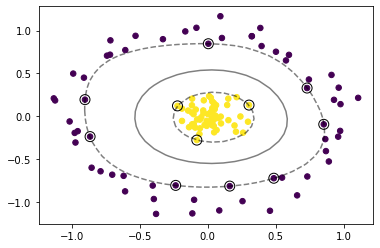

In [34]:
# rbf kernel to solve non-linearly separable data
clf = svm.SVC(kernel='rbf', C=1000).fit(X, y) # high C to reduce misclassification

# plot data
plot_svc_decision_function(clf)

Summary:
* You can clearly see that the kernel we have used has managed to separate the classes in a non-linear way
* The above plot is mapped onto the original dimensions, but the solution worked by mapping the data into a higher dimension (3D) in order to draw a straight line through it and solve the problem (imagine a 3D contour with a slice through it to separate the classes)
* This is known as the **kernel trick** and not only does it allow the solution of complex problems, but it does so efficiently and quickly (without having to generate every possible hyperplane before deciding which to use)

### Tuning and Optimizing Hyperparameters (Softening Margins)
Steps:
* Generate clusters which cannot be separated perfectly (i.e. overlapping clusters)
* Demonstrate SVM solution with different values of C

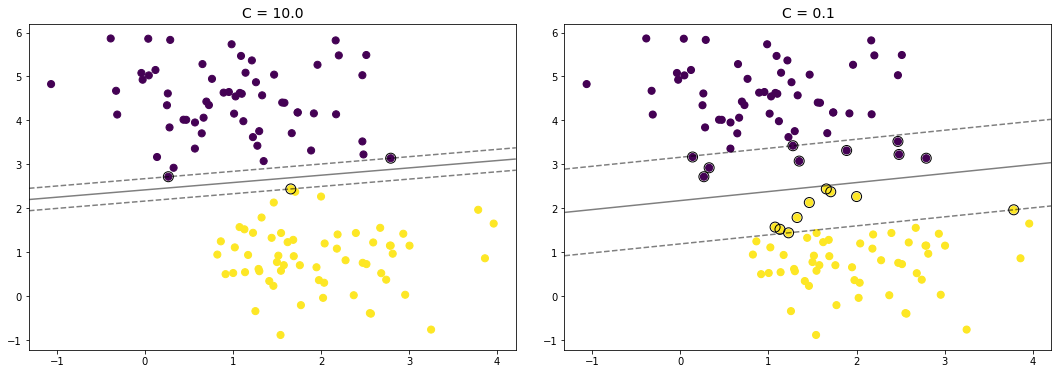

In [48]:
# generate overlapping clusters which cannot be separated perfectly
X, y = make_blobs(n_samples=120, centers=2, random_state=0, cluster_std=0.8)

# define figure for side by side plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# high and low C plots
for axi, C in zip(ax, [10.0, 0.1]):
    
    # create model
    clf = svm.SVC(kernel='linear', C=C).fit(X, y)
    
    # scatter plot data
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50)
    
    # plot SVM solution
    plot_svc_decision_function(clf, axi)
    
    # plot support vector highlights
    axi.scatter(clf.support_vectors_[:, 0],
                clf.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    
    # plot titles
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Summary:
* You can see that a higher value of C results in a stricter margin, where misclassification is reduced
* The lower C value is more flexible/has a softer margin, allowing more misclassification
* Essentially, lower C values are less overfitted/more underfitted and generalize better for real/new data (providing the value isn't so small that the model is an incredibly loose fit)

### Further Reading
Links:
* [SVM RBF in Depth](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)